# Setup
***

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "3_classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the MNIST Dataset
***

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
type(X)

numpy.ndarray

In [8]:
type(y)

numpy.ndarray

In [9]:
pd.Series(y).value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

- fairly evenly distributed

## Quick Exploration of Data

In [10]:
first_digit = X[0]

In [11]:
first_digit

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [12]:
first_digit.shape

(784,)

Saving figure some_digit_plot


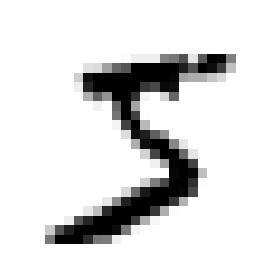

In [13]:
def plot_digit(digit):
    digit_image = digit.reshape(28, 28)
    plt.imshow(digit_image, cmap=mpl.cm.binary)
    plt.axis("off")
    plt.plot() # jupyter auto plots so this isn't necessary but it also doesn't hurt to add

plot_digit(first_digit)
save_fig("some_digit_plot")

In [14]:
y[0]

'5'

- as we can see each row is composed of 784 features or pixels with values 0 to 255 and creates a 28x28 image of a digit
- the image of the first digit does indeed look like five
- note that the label return value is not an int but a str

In [15]:
y = y.astype(np.uint8)

- saves memory rather than saving as int64

In [16]:
print("Memory usage of y as array of int64: {} bytes".format(sys.getsizeof(y.astype(int))))
print("Memory usage of y as array of uint8: {} bytes".format(sys.getsizeof(y)))

Memory usage of y as array of int64: 560112 bytes
Memory usage of y as array of uint8: 70112 bytes


In [17]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


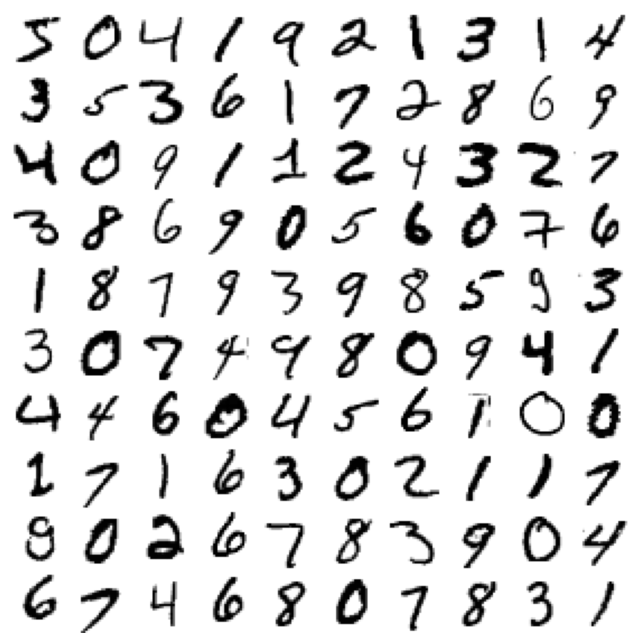

In [18]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

## Creating Train and Test Sets

In [19]:
X_train, X_test = X[:60000, :], X[60000:, :]
y_train, y_test = y[:60000], y[60000:]

- just added extra `, :` so that it is clear the feature data is a 2D array
- MNIST dataset is already shuffled and split with the first 60,000 being training data and the last 10,000 being test set data

<div class="alert alert-block alert-warning">
Keep in mind that the MNIST dataset does not have any missing data and it is already processed! (like converting handrawn digits to 28x28 images and then transforming this into 784 pixel features)<br>
<br>
Thus we can directly jump to model selection, otherwise we would definitely need to fully understand the data and prepare/process it for ML algorithms.
</div>

# Starting With a Binary Classifier
***

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [21]:
from sklearn.linear_model import SGDClassifier

In [22]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
sgd_clf.predict([first_digit])

array([ True])

In [24]:
from sklearn.model_selection import cross_val_score

# cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy", cv=3)
# >>> array([0.95035, 0.96035, 0.9604 ])

array([0.95035, 0.96035, 0.9604 ])

- wow! great! right? right??? NOOOOO! There are only like 90% of the set == not a 5 ...
    - this means even using a dumb model that just predicts a negative (not a 5) will achieve 90% accuracy
    - we need to use precision and recall to properly evaluate our model

# Performance Measures for Binary Classification
***

## Cross Validation Accuracy

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # new unfitted estimator with same parameters

In [26]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_indices, test_indices in skf.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train_5[train_indices]
    X_test_fold = X_train[test_indices]
    y_test_fold = y_train_5[test_indices]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_5_clf = Never5Classifier()
# cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# >>> array([0.91125, 0.90855, 0.90915])

array([0.91125, 0.90855, 0.90915])

- as we can see above - just by predicting only negatives (not 5) we achieved 90% accuracy due to the disproportionate amount of positives to negatives

## Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix

In [31]:
y_pred_5 = sgd_clf.predict(X_train)
cnf_mtrx = confusion_matrix(y_train_5, y_pred_5)

cnf_mtrx

array([[52316,  2263],
       [  601,  4820]])

- So we have 52316 true negatives (row 1 is observed negative and col 1 is predicted negative)
- 2263 false positives (row 1 is observed negative but col 2 predicted positive)
- 601 false negatives (row 2 is observed positive but col 1 is predicted negative)
- 4820 true positives (row 2 is observed positive and col 2 is predicted positive)

In [53]:
from sklearn.model_selection import cross_val_predict

y_pred_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cnf_mtrx = confusion_matrix(y_train_5, y_pred_5)

In [56]:
cnf_mtrx

array([[53892,   687],
       [ 1891,  3530]])

Now it doesn't look so accurate! 

## Precision and Recall

In [57]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_pred_5)

0.8370879772350012

In [60]:
# TP over TP + FP
cnf_mtrx[1, 1] / (cnf_mtrx[1, 1] + cnf_mtrx[0, 1])

0.8370879772350012

In [58]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_pred_5)

0.6511713705958311

In [61]:
# TP over TP + FN
cnf_mtrx[1, 1] / (cnf_mtrx[1, 1] + cnf_mtrx[1, 0])

0.6511713705958311

- precision is how many we got right out of all predicted positives
- recall is how many we got right out of all observed positives

Basically a high recall means we have less false negatives but more false positives. <br>
A high precision means we have few false positives but that's because the threshold used is higher and we have much more false negatives.

In [59]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_pred_5)

0.7325171197343846

- the f1 score is like a mean of precision and recall. But, personally, I think it's rather useless because unless both precision and recall for your model are terribly low, your decision is ultimately about the tradeoff between precision and recall based on the needs and context to which your model will be used

## Precision-Recall Tradeoff: Looking at Threshold

In [36]:
confidence_scores = sgd_clf.decision_function(X_train)
confidence_scores

array([  2164.22030239,  -5897.37359354, -13489.14805779, ...,
         6007.43513003,   -695.89564908,  -3991.49590678])

- These should be the confidence scores for which the classifier makes a decision. If the score is above zero then it will predict a positive

Let's make our own predictions using the decision_function and passing our own theshold.

In [43]:
# needs a decision function
class ThreshClassifier(BaseEstimator):
    def __init__(self, classifier=sgd_clf.decision_function, threshold=0):
        self.classifier = classifier
        self.threshold = threshold
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return self.classifier(X) >= self.threshold

In [44]:
sgd_thresh_clf = ThreshClassifier(sgd_clf.decision_function, threshold=5000)

# no need to fit since sgd_clf is already fitted
y_pred_5_5000 = sgd_thresh_clf.predict(X_train)

In [45]:
precision_score(y_train_5, y_pred_5_5000)

0.9754335260115607

- with a high threshold like 5000, this means instances that the classifier is less confident about will be predicted as negative and only instances that have a high confidence of being positive (aka being a 5) will be predicted positive
- the upside is that our precision is high which means out of all the 5s we predicted, most of them are indeed 5s
- the downside is that many 5s will be falsely predicted as negative (aka not a 5) which means our recall should be low

In [46]:
recall_score(y_train_5, y_pred_5_5000)

0.37354731599335916

RIP to our recall lol! But this is precision-recall tradeoff!
- We would sometimes want high precision - e.g. a model that selects worthy applicants to a job that is extremely popular and gets over 10,000 applicants. You'd rather have high precision so that your human interviewers will interview great candidates because it takes a long time to do human interviews. Although you may miss some good applicants, the job is popular enough for it not to matter

In [47]:
sgd_thresh_clf = ThreshClassifier(sgd_clf.decision_function, threshold=-2000)

y_pred_5_m2000 = sgd_thresh_clf.predict(X_train)

In [49]:
precision_score(y_train_5, y_pred_5_m2000)

0.3848550025958615

In [50]:
recall_score(y_train_5, y_pred_5_m2000)

0.9572034679948349

RIP to our precision!
- We would also want high recall sometimes -e.g. a model that detects if a person has cancer or some other medical issue. You'd much rather catch on to serious diseases early even if you'd get false alerted many times and waste some money.

## Precision-Recall Tradeoff: Visualizing Precision and Recall Over Threshold

In [88]:
confidence_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                                      method="decision_function", cv=3)
confidence_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [89]:
from sklearn.metrics import precision_recall_curve

- what precision_recall_curve does is simple. It takes the observed values, and a similar length array of confidence scores and basically tests a range of threshold values
    - for each threshold value it will compare the confidence scores and predict a positive if greater and negative if less than. The resulting predictions are then compared to the observed values and precision and recall are calculated.
    - basically, you get an array of thresholds and a same-length array of precision and recall scores for each threshold based on the parameters: observed values, confidence scores (which comes from a classifier)

In [90]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, confidence_scores)

In [91]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

- plots precision values and recall values (y-axis) over threshold values (x-axis)

In [92]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

- precisions >= 0.90 will return an array of True and Falses aka 1s and 0s
- argmax will return the index (or indices if axis is specified - like the indices of the max value in every row or every col) of the max value
    - in this case the max is all 1s, so it will automatically return the index of the earliest 1 - which would be the index of the precision value that is >= 0.90 but also closest to 0.90

Saving figure precision_recall_vs_threshold_plot


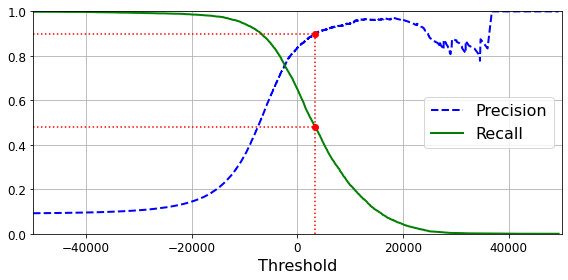

In [94]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") # plots a vertical line from 0 to 0.9 at threshold_90_precision
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") # horizontal line from -50K to threshold_90_precision at 0.9
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # same as above but at recall_90_precision height
plt.plot([threshold_90_precision], [0.9], "ro") # red dot at y = precision_90 or .9 and x = threshold_90_precision
plt.plot([threshold_90_precision], [recall_90_precision], "ro") # same red dot but y = recall_90_precision
save_fig("precision_recall_vs_threshold_plot")
plt.show()

- we can see that if we want 90% precision, the threshold will be slightly greater than 0 and recall will be less than 50%
- this plot perfectly shows what precision-recall tradeoff is and how threshold is the deciding variable

Saving figure precision_vs_recall_plot


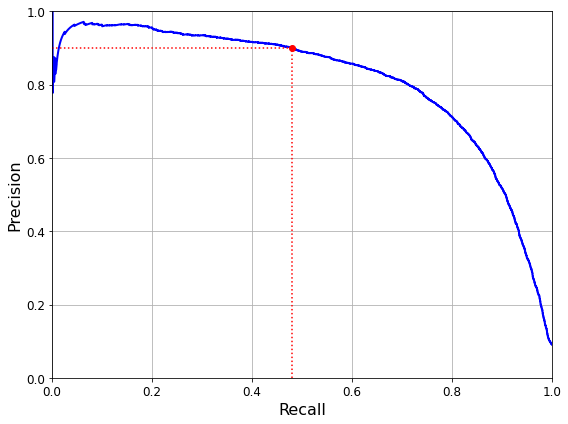

In [95]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

- Here is another helpful graph that directly shows you the tradeoff between precision and recall
- the red dot is once again at 90% precision and we can see that Recall will drop to lower than 50%

In [96]:
threshold_90_precision

3370.0194991439557

In [97]:
y_pred_5_p90 = (confidence_scores >= threshold_90_precision)

precision_score(y_train_5, y_pred_5_p90)

0.9000345901072293

In [98]:
recall_90_precision

0.4799852425751706

In [99]:
recall_score(y_train_5, y_pred_5_p90)

0.4799852425751706

## ROC Curve

In [100]:
from sklearn.metrics import roc_curve

In [107]:
fpr, tpr, thresholds = roc_curve(y_train_5, confidence_scores)

Saving figure roc_curve_plot


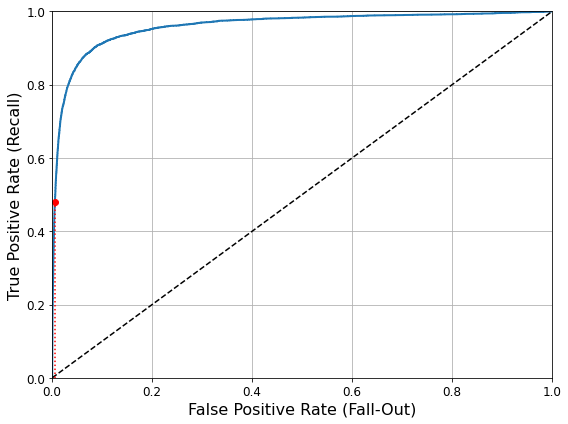

In [108]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

- basically you want your classifier to be vertical then top left corner then horizontal
    - this is because you want to be able to increase recall (aka predict more positives as positives) without increasing mistakes (aka predicting negatives as positives)

You want to use Precision-Recall curve when there is a disproportionate amount of positives to negatives.<br>
ROC Curve will not be representative when the ratio is vastly different because you could predict more positives and the Fall-Out won't increase because the amount of false positives is small compared to all observed negatives

In [111]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, confidence_scores)

0.9604938554008616

Let's try using a RandomForestClassifier and calculating the corresponding scores.

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
forest_clf = RandomForestClassifier(random_state=42)

In [120]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                       method="predict_proba", cv=3)

In [121]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [122]:
y_scores_forest = y_probas_forest[:, 1] # scores = probability of positive
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


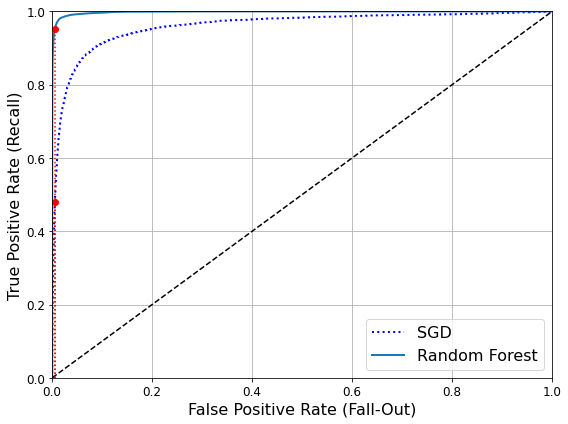

In [123]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [125]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [126]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [127]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification

In [128]:
from sklearn.svm import SVC

In [129]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # all 10 labels 0 to 9

SVC()

- sklearn automatically implements OvR or OvO for binary classifiers; the SVC above implements OvO, so it trains 45 classifiers
    - the good thing about OvO is that the classifiers only have to train on the part of the data that result in the two classes it predicts on, so it can be good for large datasets

In [133]:
svm_clf.predict([first_digit])

array([5], dtype=uint8)

In [132]:
svm_clf.decision_function([first_digit])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

- the one with the most duel wins was indeed the 5th class with 9.31 wins

In [135]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [136]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([first_digit])

array([5], dtype=uint8)

If you run cross_val_score with sgd_clf, sklearn will automatically apply OvR and you will have 10 classifiers with 10 confidence scores and the prediction will be the class with the highest score.
- with Standard Scaling on the training data the resulting accuracy scores from cross_val_score is `array([0.8983, 0.891 , 0.9018])`

In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

- will take too long to run, just understand that it applies OvO and that you should do data preparation because it really does increase accuracy by a lot

# Error Analysis
***

In [138]:
y_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [174]:
y_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [140]:
cnf_mtrx = confusion_matrix(y_train, y_pred)
cnf_mtrx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

- Let's plot this with a cmap to visualize it better

Saving figure confusion_matrix_plot


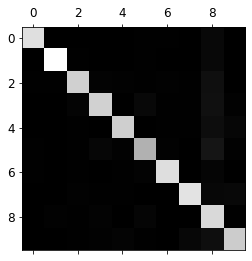

In [168]:
plt.matshow(cnf_mtrx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [145]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

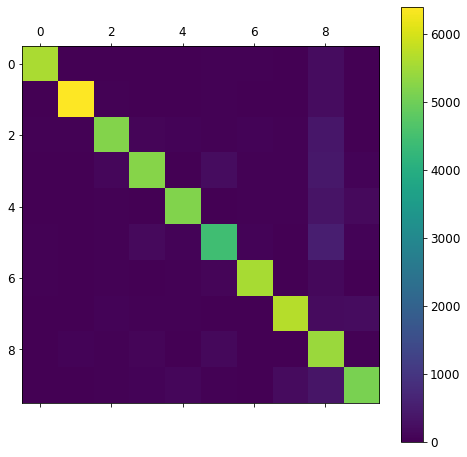

In [146]:
plot_confusion_matrix(cnf_mtrx)

- we want the rates - ratio of this prediction to the total observed

In [163]:
row_sums = cnf_mtrx.sum(axis=1, keepdims=True) # total number of each class (observed not predicted)
norm_cnf_mtrx = cnf_mtrx / row_sums

Saving figure confusion_matrix_errors_plot


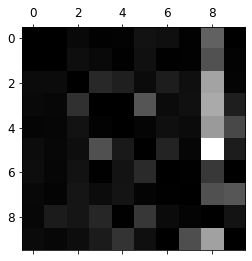

In [166]:
np.fill_diagonal(norm_cnf_mtrx, 0)
plt.matshow(norm_cnf_mtrx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

- as we can see, the precision of 8 is really bad, 5 has bad recall and bad precision, 3 too

In [170]:
y_train_8 = (y_train == 8)

sgd_clf_8 = SGDClassifier()

y_pred_8 = cross_val_predict(sgd_clf_8, X_train, y_train_8,
                             method="decision_function", cv=3)

In [172]:
precision_score(y_train_8, y_pred_8>0)

0.45163718479488146

Saving figure error_analysis_digits_plot


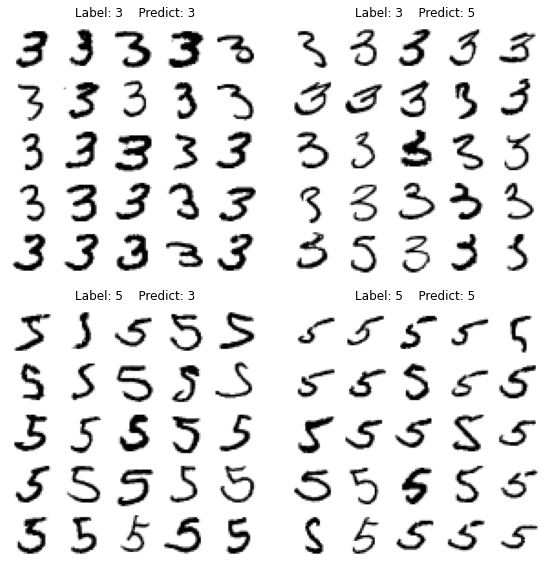

In [181]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_pred == cl_a)] # get 784 pixels where observed class a and predicted class a
X_ab = X_train[(y_train == cl_a) & (y_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_pred == cl_a)]

plt.figure(figsize=(8,8))
plt.subplot(221, title="Label: {}    Predict: {}".format(cl_a, cl_a)); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222, title="Label: {}    Predict: {}".format(cl_a, cl_b)); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223, title="Label: {}    Predict: {}".format(cl_b, cl_a)); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224, title="Label: {}    Predict: {}".format(cl_b, cl_b)); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification

In [183]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = (y_train % 2) == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [184]:
knn_clf.predict([first_digit])

array([[False,  True]])

- this is true! 5 is not large (False) and odd (True)

In [ ]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

- the averaged f1_score of all instances was 0.976410265560605
    - would take hours to run

# Multioutput Classification

In [192]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train # the result or label is multilabel (784 labels per pixel) and multioutput (each label is 0 to 255)
y_test_mod = X_test

Let's plot one of the instances and its label

Saving figure noisy_digit_example_plot


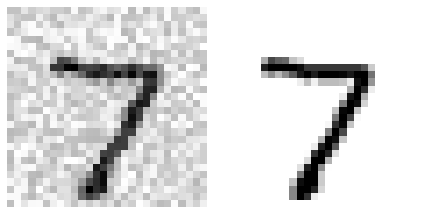

In [196]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [195]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

Saving figure cleaned_digit_example_plot


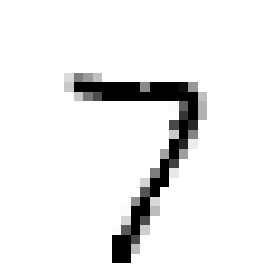

In [201]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")